In [1]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import os
import polars as pl
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from datetime import datetime as dt
from support.pd_support import *
from support.ar_calculations import *

import toml
import plotly.io as pio
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
pio.renderers.default = "vscode"
import seaborn as sns

from support.ar_calculations import calculate_rotmat_from_xyo, calculate_rotmat

In [2]:
toml.load('DATA_PATH.toml')

{'data_path': {'directory': 'D:\\CMC\\pyprojects\\DeepVision\\recorded_data'},
 'parameters': {'t': 'float',
  'f1': 'float',
  'f2': 'float',
  'f3': 'float',
  'f4': 'float',
  'cop_x': 'float',
  'cop_y': 'float',
  'weight': 'float'}}

In [3]:
_pth = toml.load('DATA_PATH.toml')['data_path']['directory']
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_00"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)
_folder_name = 'angle_est_0'

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "angle_rotmat.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

## Mocap data

In [4]:
m1 = get_rb_marker_name(1)
m2 = get_rb_marker_name(2)
m3 = get_rb_marker_name(3)
m4 = get_rb_marker_name(4)

In [5]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):

    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, True, flags= cv2.SOLVEPNP_ITERATIVE)
        
        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
        
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [6]:
_teensy_df = pl.read_csv(os.path.join(_base_pth,_folder_name,"imu01.csv"))
_teensy_df = _teensy_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))
t_time = _teensy_df["rust_time"].to_numpy()
t_time = [dt.fromtimestamp(t) for t in t_time]
# t_time = [dt.strftime(t) for t in t_time]
teensy_df = pl.DataFrame({"time":t_time,"sync":_teensy_df["sync"]})
idx = None
for idx, i in enumerate(teensy_df['sync']):
    if i == 1:
        break
teensy_start_time = teensy_df['time'][idx]

# Aruco parameters

ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
        size= [1,1],
        markerLength=markerLength,
        markerSeparation=markerSeperation,
        dictionary=ARUCO_DICT)

# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [7]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedpoints = detector.detectMarkers(_frame)
    # refine corners
    corners, ids, rejectedpoints,_ = detector.refineDetectedMarkers(image=_frame,board=board ,detectedCorners=corners, detectedIds=ids, rejectedCorners=rejectedpoints, cameraMatrix=_webcam_cam_mat, distCoeffs=_webcam_dist)
    rvec, tvec  = estimatePoseSingleMarkers(corners=corners, marker_size=markerLength, mtx=_webcam_cam_mat, distortion=_webcam_dist)

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(tvec)
        data["rvec"].append(rvec)

    counter+=1
_video_file.close()

0it [00:00, ?it/s]

7313it [00:39, 183.62it/s]


In [8]:
coordinate = {str(default_ids[0]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[1]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[2]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = []
# default_ids = [100, 49, 80]
zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])
            
        _zero_counter = 0            
        for j, _m in enumerate(data["marker_ids"][i]):
                
            if _m in default_ids:
                coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

                
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
            
    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)
            
    doesnt_exist.clear()

## Getting time sync and trigger

In [9]:
ar_df = pl.DataFrame(coordinate['88'])
_tts = pl.DataFrame(ts).rename({"column_0":"time", 'column_1':'_sync'})
_sync = _tts['_sync'].to_numpy()
for i in range(len(_sync)):
    if _sync[i] == 'NA':
        _sync[i] = np.nan
    else:
        _sync[i] = int(_sync[i])

_tts.insert_column(1, pl.Series('sync',np.array(_sync, dtype=np.float32)))
ar_df.insert_column(0, _tts['time'])
ar_df.insert_column(1, _tts['sync'])
ar_df = ar_df.with_columns((pl.col('sync')/pl.col('sync')).alias('trigger'))
_

## Reading mocap

In [1]:
_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)),_folder_name.split('_')[0], f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df = pl.from_pandas(_mocap_df)

cumulative = _mocap_df[[m1['x'], m1['y'], m1['z']]].to_numpy().T + _mocap_df[[m2['x'], m2['y'], m2['z']]].to_numpy().T + _mocap_df[[m3['x'], m3['y'], m3['z']]].to_numpy().T + _mocap_df[[m4['x'], m4['y'], m4['z']]].to_numpy().T
cumulative = cumulative/4

_m_df = pl.DataFrame({"time":_mocap_df["time"], "x":cumulative[0], "y":cumulative[1], "z":cumulative[2]})

NameError: name 'os' is not defined

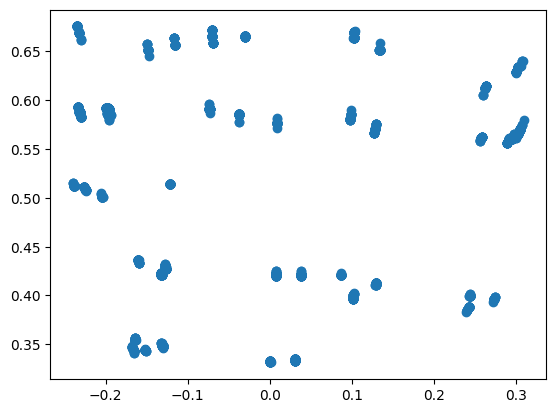

In [11]:
plt.scatter(ar_df['trigger']*ar_df['x'], ar_df['trigger']*ar_df['z'])

In [12]:
_ang = []
for i in range(len(_mocap_df)):
    try:
        arr = R.from_quat(_mocap_df[['rb_ang_x', 'rb_ang_y', 'rb_ang_z', 'rb_ang_w']].to_numpy()[i]).as_euler('ZYX', degrees=True)
    except:
        arr = np.array([np.nan, np.nan, np.nan])
    _ang.append(arr)

In [13]:
_ang = np.array(_ang)

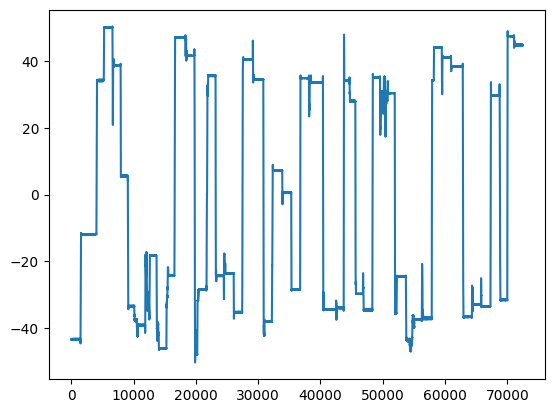

In [14]:
plt.plot(-_ang[:,1])

In [15]:
_rvecs = []

for i in range(len(ar_df['sync'])):
    if ar_df['sync'][i] == 1:
        _rvecs.append(ar_df[['rx','ry','rz']][i].to_numpy())
_rvecs = np.array(_rvecs).reshape(-1, 3)

In [16]:
if not (type(ar_df['time'][0])) == type(dt.now()):
    ar_df = ar_df.with_columns([pl.Series(name='time', values=[dt.fromtimestamp(i) for i in ar_df['time'].to_numpy()]).alias('time')])

In [17]:
rmat = []
_rotated = []
for i in range(len(ar_df['rx'])):
    rmat.append(cv2.Rodrigues(ar_df[['rx', 'ry', 'rz']][i].to_numpy())[0])
    _rotated.append(rmat[i].T @ _ar_lframe_rot)

In [18]:
_theta_y = R.from_matrix(_rotated).as_euler('ZYX', degrees=True)[:,1]

In [19]:
f = interp1d(ar_df['time'].dt.epoch(), ar_df['trigger'], kind='linear', fill_value='extrapolate')
mocap_trigger = f(_m_df['time'].dt.epoch())

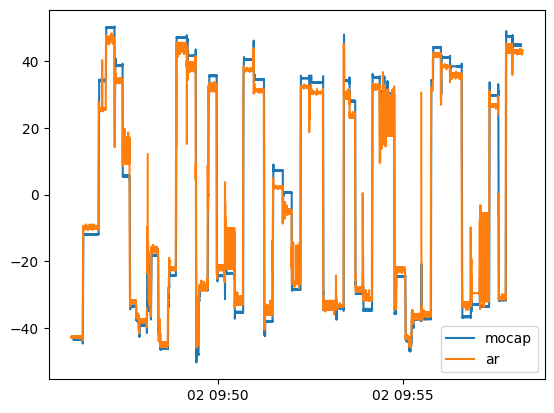

In [20]:
plt.plot(_mocap_df['time'], -_ang[:,1], label = 'mocap')
plt.plot(ar_df['time'], _theta_y + 43, label = 'ar')
plt.legend()

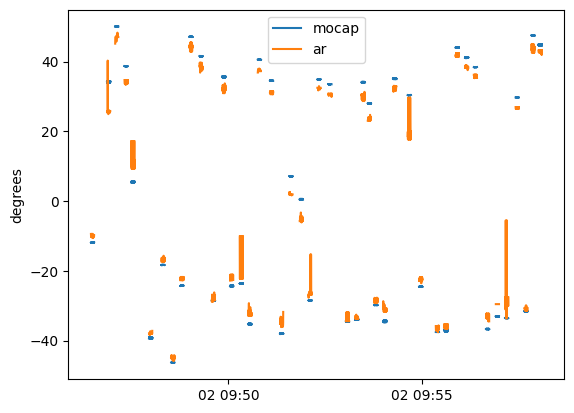

In [21]:
plt.plot(_mocap_df['time'], -_ang[:,1]* mocap_trigger, label="mocap")
plt.plot(ar_df['time'], (_theta_y + 43)*ar_df['trigger'], label="ar")
plt.ylabel('degrees')
plt.legend()

In [22]:
ar_f = interp1d(ar_df['time'].dt.epoch(), _theta_y, kind='linear', fill_value='extrapolate')
ar_ang = ar_f(_m_df['time'].dt.epoch())

Text(0, 0.5, 'degrees')

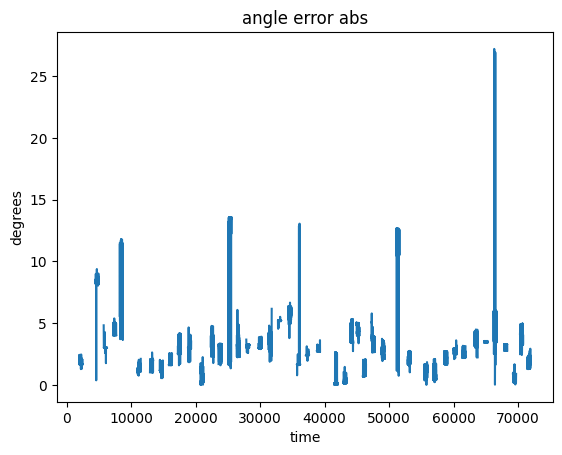

In [23]:
plt.plot(abs(-_ang[:,1]* mocap_trigger - (ar_ang+43)))
plt.title('angle error abs')
plt.xlabel('time')
plt.ylabel('degrees')

In [24]:
ang_df = pl.DataFrame(pl.Series('ang',abs(-_ang[:,1]* mocap_trigger - (ar_ang+43))))['ang'].drop_nans()

Text(0.5, 1.0, 'angle error boxplot')

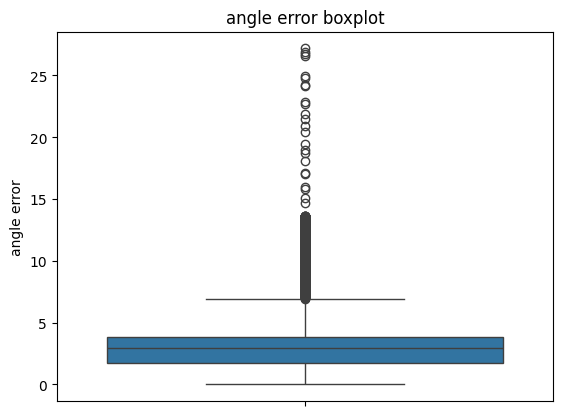

In [25]:
sns.boxplot(data=ang_df)
plt.ylabel('angle error')
plt.title('angle error boxplot')